In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [8]:
train = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_training.csv")
test = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_testing.csv")

# Preprocessiong
* * * *

欠損値も特にないため、省略

# 交差検証いろいろ
* * * * *

In [9]:
train_target = train.compositeHourlyWages.values

test_ID = test['ID']
test.drop("ID", axis = 1, inplace = True)

train.drop(['compositeHourlyWages'], axis=1, inplace=True)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train,train_target,test_size=0.2,random_state=0)

### 1. Validation with local train
ホールドアウトして（train_test_splitを使ってx_trainなどを作る）、trainとtestを使ってから評価するケース。

In [11]:
# xgboostモデルの作成
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

# パラメータを設定したい場合は下記のように設定も可能
#ind_params = {'objective': 'reg:linear'}
#reg = xgb.XGBRegressor(**ind_params)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
y_trainprediction = reg.predict(X_train)
y_testprediction = reg.predict(X_test)

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("RMSE from local train: ", rmse(y_test, y_testprediction))
print("MSE from local train: ", mean_squared_error(y_test, y_testprediction))
print("R2 from local train: ", r2_score(y_test, y_testprediction))

RMSE from local train:  6.02475299555
MSE from local train:  36.2976486573
R2 from local train:  0.395235324935


#### まとめ
**Pros**
- 簡単。

**Cons**
- 8対2で分けているだけなので、データの偏りがある場合評価は低いことが予想される。

### 2. Validation with GridSearch
実はGridsearchする際にも交差検証が実施できる。一挙両得で便利。

In [21]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [10]:
# xgboostモデルの作成
xgr = xgb.XGBRegressor()

# XGBoost params
xgb_params = {
    'objective' : ['reg:gamma','reg:linear'],
    'learning_rate' : [0.05,0.1],
    'n_estimators' : [50,100,200],
    'max_depth' : [2,4,6],
    'subsample' : [0.8,0.85,0.9,0.95],
    'colsample_bytree' : [0.5,1.0],
    'min_child_weight' : [5,10,15]
}

In [11]:
#scoring_func = make_scorer(mean_squared_error)
#grid = GridSearchCV(xgr,xgb_params,scoring=scoring_func,cv=5,n_jobs=-1)

grid = GridSearchCV(xgr,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['reg:gamma', 'reg:linear'], 'learning_rate': [0.05, 0.1], 'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6], 'subsample': [0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.5, 1.0], 'min_child_weight': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [12]:
print("Best params: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)
print("MSE: ", grid.best_score_)

# best_score_ : Mean cross-validated score of the best_estimator

Best params:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 15, 'n_estimators': 100, 'objective': 'reg:gamma', 'subsample': 0.8}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=15, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
MSE:  -38.8108460369


In [13]:
# The result of combination
#index = 1
#for params, mean_score, scores in grid.cv_results_:
#    print("%d) %0.3f (+/-%0.03f) " % (index, mean_score, scores.std() / 2))
#    print("Params: %r" % params)
#    print("_"*30)
#    index = index + 1

In [ ]:
# 改めて最適パラメータで学習

In [21]:
#gdm = xgb.XGBRegressor(**grid.best_params_) でもよし

xgb_params = {
    "booster"  :  "gbtree", 
#    "objective"         :  "binary:logistic",
    "objective"         :  "reg:gamma",
    "tree_method": "hist",
    "eval_metric": "auc",
    "eta": 0.1,
    "max_depth": 5,
    "min_child_weight": 10,
    "gamma": 0.70,
    "subsample": 0.76,
    "colsample_bytree": 0.95,
    "nthread": 6,
    "seed": 0,
    'silent': 1
}

xgr = xgb.XGBRegressor(**xgb_params) 
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, eta=0.1, eval_metric='auc', gamma=0.7,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=10, missing=None, n_estimators=100, n_jobs=1,
       nthread=6, objective='reg:gamma', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=1, subsample=0.76,
       tree_method='hist')

In [22]:
y_testprediction = xgr.predict(X_test)

In [23]:
# The error metric: RMSE
print("RMSE from local train: ", rmse(y_test, y_testprediction))
print("MSE from local train: ", mean_squared_error(y_test, y_testprediction))
print("R2 from local train: ", r2_score(y_test, y_testprediction))

RMSE from local train:  6.00850970197
MSE from local train:  36.1021888387
R2 from local train:  0.398491932404


#### まとめ
**Pros**
- GridsearchしながらCVもできて簡単。

**Cons**
- だがCVするために、いつもGridsearchしないといけないので、使うのはGridsearchする時の1回目くらいでしょうか。CVは別途行うので、cv=xの数を初めから小さく設定しておくか。とりあえず最初からcv=5で行くのが良さそう。
- CVするから時間がかかる。。。

### 3. Validation with sklearn cv (normal k-fold)
sklearnにcross_val_scoreがあるのでライブラリを初めから使ってしまう。

In [24]:
scores = cross_val_score(xgr, train, train_target, scoring = "neg_mean_squared_error",cv=5)
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

for i, score in enumerate(scores):
    print('Fold %4d: MSE= %s'% (i, score))
    
# Scoring types: http://scikit-learn.org/stable/modules/model_evaluation.html

MSE: -38.69 (+/- 8.68)
Fold    0: MSE= -42.1454030379
Fold    1: MSE= -37.9734614077
Fold    2: MSE= -33.1404770954
Fold    3: MSE= -44.9406937328
Fold    4: MSE= -35.2493473437


#### まとめ
**Pros**
- コードが短くて見やすいし、簡単にCVができて良い。
- KfoldやStratified Kfoldなども考慮されている
> [For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)。

**Cons**
- StackingでOut-of-foldの生成をすることができない。各foldごとのモデルを保存・予測が必要で、cross_val_scoreでは学習させたモデルを触ることができないため、利用できない。
- Scoringの種類が限らていて、rmsleとかはできない？。よって、あとで紹介する自分でmetrics.KFoldなど使わう方法でないと無理そう。

### 4. Validation with sklearn cv (Stratified k-fold)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=2017)

scores = cross_val_score(gdm, train, train_target, scoring = "neg_mean_squared_error",cv=skf)
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

for i, score in enumerate(scores):
    print('Stratified-Fold %4d: MSE= %s'% (i, score))

/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


MSE: -33.20 (+/- 17.66)
Stratified-Fold    0: MSE= -50.7753717825
Stratified-Fold    1: MSE= -27.6839607022
Stratified-Fold    2: MSE= -28.770991798
Stratified-Fold    3: MSE= -28.4326640183
Stratified-Fold    4: MSE= -30.3428421976


#### まとめ
**3. Validation with sklearn cv (normal k-fold)** と同じ。

※Stratified Kfoldは主に**分類**か、**yが整数またはクラスタ分類** 時に使うべき、な気がする。

> [For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)。


### 5. Validation without cross_val_score
cross_val_scoreを使わないで自分でcvのコードを各方法。先人の知恵を拝借。

**5.1. （参考）YifanのCV用関数**

**5.1.1. sklearn K-fold & OOF function**

CV用の関数がかっこよくまとまっていたので、参考に。そもそもStackingのOut-of-foldを作るように作成されていたのですた、簡単にCVスコアも見れるのでこちらをこれから使います。

In [ ]:
from sklearn.model_selection import StratifiedKFold,KFold

### Kfold or Stratified Kfold
kf=KFold(n_splits=5, shuffle=True, random_state=2017)
#kf=StratifiedKFold(n_splits=5, shuffle=True, random_state=2017)

### Criterion function
def auc_to_gini_norm(auc_score):
    return 2*auc_score-1

def eval_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_rmsle(y, pred):
    return mean_squared_error(y, pred)**0.5

In [ ]:
### Modified cross-validation function copied from Yifan's cool kernel. 
### Source: https://www.kaggle.com/yifanxie/porto-seguro-tutorial-end-to-end-ensemble

def cross_validate_sklearn(clf, x_train, y_train, x_test, kf, scale=False, verbose=True):
    start_time=time.time()
    
    # initialise the size of out-of-fold train an test prediction
    train_pred = np.zeros((x_train.shape[0]))
    test_pred = np.zeros((x_test.shape[0]))

    # use the kfold object to generate the required folds
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        # generate training folds and validation fold
        x_train_kf, x_val_kf = x_train.loc[train_index, :], x_train.loc[test_index, :]
        y_train_kf, y_val_kf = y_train[train_index], y_train[test_index]

        # perform scaling if required i.e. for linear algorithms
        if scale:
            scaler = StandardScaler().fit(x_train_kf.values)
            x_train_kf_values = scaler.transform(x_train_kf.values)
            x_val_kf_values = scaler.transform(x_val_kf.values)
            x_test_values = scaler.transform(x_test.values)
        else:
            x_train_kf_values = x_train_kf.values
            x_val_kf_values = x_val_kf.values
            x_test_values = x_test.values
        
        ###################################################
        # Please update for your own criterion 
        ###################################################
        # fit the input classifier and perform prediction.
        #clf.fit(x_train_kf_values, y_train_kf.values)
        clf.fit(x_train_kf_values, np.log1p(y_train_kf.values))

        ###################################################
        # Please update for your own criterion 
        ###################################################
        #val_pred=clf.predict_proba(x_val_kf_values)[:,1]
        val_pred=clf.predict(x_val_kf_values)

        train_pred[test_index] += val_pred

        ###################################################
        # Please update for your own criterion 
        ###################################################
        #y_test_preds = clf.predict_proba(x_test_values)[:,1]
        y_test_preds = clf.predict(x_test_values)
        test_pred += y_test_preds

        ###################################################
        # Please update for your own criterion 
        ###################################################
        #fold_auc = roc_auc_score(y_val_kf.values, val_pred)
        #fold_gini_norm = auc_to_gini_norm(fold_auc)
        fold_rmsle = eval_rmsle(np.log1p(y_val_kf.values), val_pred)

        if verbose:
            ###################################################
            # Please update for your own criterion
            ###################################################

            #print('fold cv {} AUC score is {:.6f}, Gini_Norm score is {:.6f}'.format(i, fold_auc, fold_gini_norm))
            print('fold cv {} RMSLE score is {:.6f}'.format(i, fold_rmsle))

    test_pred /= kf.n_splits

    ###################################################
    # Please update for your own criterion
    ###################################################
    #cv_auc = roc_auc_score(y_train, train_pred)
    #cv_gini_norm = auc_to_gini_norm(cv_auc)
    cv_rmsle = eval_rmsle(np.log1p(y_train), train_pred)
        
    #cv_score = [cv_auc, cv_gini_norm]
    cv_score = [cv_rmsle]
    if verbose:

        ###################################################
        # Please update for your own criterion
        ###################################################
        #print('cv AUC score is {:.6f}, Gini_Norm score is {:.6f}'.format(cv_auc, cv_gini_norm))
        print('cv RMSLE score is {:.6f}'.format(cv_rmsle))
        end_time = time.time()
        print("it takes %.3f seconds to perform cross validation" % (end_time - start_time))
    return cv_score, train_pred, test_pred


In [ ]:
rfr = RandomForestRegressor(criterion='mse',
                            max_depth=5,
                            n_estimators=500,
                            min_samples_leaf=5,
                            min_samples_split=2
                           )

outcomes =cross_validate_sklearn(rfr, x_train, y_train ,x_test, kf, scale=False, verbose=True)

**5.1.2. Xgboost K-fold & OOF function**

Work in progress

In [ ]:
def probability_to_rank(prediction, scaler=1):
    pred_df=pd.DataFrame(columns=['probability'])
    pred_df['probability']=prediction
    pred_df['rank']=pred_df['probability'].rank()/len(prediction)*scaler
    return pred_df['rank'].values

In [ ]:
def cross_validate_xgb(params, x_train, y_train, x_test, kf, cat_cols=[], verbose=True, 
                       verbose_eval=50, num_boost_round=4000, use_rank=True):
    start_time=time.time()

    train_pred = np.zeros((x_train.shape[0]))
    test_pred = np.zeros((x_test.shape[0]))

    # use the k-fold object to enumerate indexes for each training and validation fold
    for i, (train_index, val_index) in enumerate(kf.split(x_train, y_train)): # folds 1, 2 ,3 ,4, 5
        # example: training from 1,2,3,4; validation from 5
        x_train_kf, x_val_kf = x_train.loc[train_index, :], x_train.loc[val_index, :]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
        x_test_kf=x_test.copy()

        d_train_kf = xgb.DMatrix(x_train_kf, label=y_train_kf)
        d_val_kf = xgb.DMatrix(x_val_kf, label=y_val_kf)
        d_test = xgb.DMatrix(x_test_kf)

        bst = xgb.train(params, d_train_kf, num_boost_round=num_boost_round,
                        evals=[(d_train_kf, 'train'), (d_val_kf, 'val')], verbose_eval=verbose_eval,
                        early_stopping_rounds=50)

        val_pred = bst.predict(d_val_kf, ntree_limit=bst.best_ntree_limit)
        if use_rank:
            train_pred[val_index] += probability_to_rank(val_pred)
            test_pred+=probability_to_rank(bst.predict(d_test))
        else:
            train_pred[val_index] += val_pred
            test_pred+=bst.predict(d_test)

        fold_auc = roc_auc_score(y_val_kf.values, val_pred)
        fold_gini_norm = auc_to_gini_norm(fold_auc)

        if verbose:
            print('fold cv {} AUC score is {:.6f}, Gini_Norm score is {:.6f}'.format(i, fold_auc, 
                                                                                     fold_gini_norm))

    test_pred /= kf.n_splits

    cv_auc = roc_auc_score(y_train, train_pred)
    cv_gini_norm = auc_to_gini_norm(cv_auc)
    cv_score = [cv_auc, cv_gini_norm]
    if verbose:
        print('cv AUC score is {:.6f}, Gini_Norm score is {:.6f}'.format(cv_auc, cv_gini_norm))
        end_time = time.time()
        print("it takes %.3f seconds to perform cross validation" % (end_time - start_time))

        return cv_score, train_pred,test_pred

**5.1.3 LigthGBM K-fold & OOF function**

Work in progress

In [ ]:
def cross_validate_lgb(params, x_train, y_train, x_test, kf, cat_cols=[],
                       verbose=True, verbose_eval=50, use_cat=True, use_rank=True):
    start_time = time.time()
    train_pred = np.zeros((x_train.shape[0]))
    test_pred = np.zeros((x_test.shape[0]))

    if len(cat_cols)==0: use_cat=False

    # use the k-fold object to enumerate indexes for each training and validation fold
    for i, (train_index, val_index) in enumerate(kf.split(x_train, y_train)): # folds 1, 2 ,3 ,4, 5
        # example: training from 1,2,3,4; validation from 5
        x_train_kf, x_val_kf = x_train.loc[train_index, :], x_train.loc[val_index, :]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

        if use_cat:
            lgb_train = lgb.Dataset(x_train_kf, y_train_kf, categorical_feature=cat_cols)
            lgb_val = lgb.Dataset(x_val_kf, y_val_kf, reference=lgb_train, categorical_feature=cat_cols)
        else:
            lgb_train = lgb.Dataset(x_train_kf, y_train_kf)
            lgb_val = lgb.Dataset(x_val_kf, y_val_kf, reference=lgb_train)

        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=4000,
                        valid_sets=lgb_val,
                        early_stopping_rounds=30,
                        verbose_eval=verbose_eval)

        val_pred = gbm.predict(x_val_kf)

        if use_rank:
            train_pred[val_index] += probability_to_rank(val_pred)
            test_pred += probability_to_rank(gbm.predict(x_test))
            # test_pred += gbm.predict(x_test)
        else:
            train_pred[val_index] += val_pred
            test_pred += gbm.predict(x_test)

        # test_pred += gbm.predict(x_test)
        fold_auc = roc_auc_score(y_val_kf.values, val_pred)
        fold_gini_norm = auc_to_gini_norm(fold_auc)
        if verbose:
            print('fold cv {} AUC score is {:.6f}, Gini_Norm score is {:.6f}'.format(i, fold_auc, fold_gini_norm))

    test_pred /= kf.n_splits

    cv_auc = roc_auc_score(y_train, train_pred)
    cv_gini_norm = auc_to_gini_norm(cv_auc)
    cv_score = [cv_auc, cv_gini_norm]
    if verbose:
        print('cv AUC score is {:.6f}, Gini_Norm score is {:.6f}'.format(cv_auc, cv_gini_norm))
        end_time = time.time()
        print("it takes %.3f seconds to perform cross validation" % (end_time - start_time))
    return cv_score, train_pred,test_pred


#### 5.2. K-fold CV

In [30]:
def eval_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [31]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
import time

In [33]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=NFOLDS, random_state=SEED)

start_time=time.time()

# initialise the size of out-of-fold train an test prediction
scores = []

for i, (train_index, test_index) in enumerate(kf.split(train, train_target)):

    x_train_kf, x_val_kf = train.loc[train_index, :], train.loc[test_index, :]
    y_train_kf, y_val_kf = train_target[train_index], train_target[test_index]
 
    # Make data as numpy
    x_train_kf_values = x_train_kf.values
    x_val_kf_values = x_val_kf.values

    x_test_values = test.values

    # fit the input classifier and perform prediction.
    gdm.fit(x_train_kf_values, y_train_kf)

    y_val_kf_pred = gdm.predict(x_val_kf_values)
    
    fold_rmse = eval_rmse(y_val_kf, y_val_kf_pred)
    print('fold cv {} RMSE score is {:.6f}\n'.format(i, fold_rmse))
    scores.append(fold_rmse)

print('cv RMSE score is {:.3f} +/- {:.3f}'.format(np.mean(scores),np.std(scores)))

end_time = time.time()
print("\nit takes %.3f seconds to perform cross validation" % (end_time - start_time))


fold cv 0 RMSE score is 6.464016

fold cv 1 RMSE score is 6.153830

fold cv 2 RMSE score is 5.701085

fold cv 3 RMSE score is 6.676302

fold cv 4 RMSE score is 5.910690

cv RMSE score is 6.181 +/- 0.355

it takes 0.174 seconds to perform cross validation


#### 5.2. Stratified K-fold CV

In [35]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=2017)

start_time=time.time()

# initialise the size of out-of-fold train an test prediction
scores = []

for i, (train_index, test_index) in enumerate(skf.split(train, train_target)):

    x_train_kf, x_val_kf = train.loc[train_index, :], train.loc[test_index, :]
    y_train_kf, y_val_kf = train_target[train_index], train_target[test_index]
 
    # Make data as numpy
    x_train_kf_values = x_train_kf.values
    x_val_kf_values = x_val_kf.values

    x_test_values = test.values

    # fit the input classifier and perform prediction.
    gdm.fit(x_train_kf_values, y_train_kf)

    y_val_kf_pred = gdm.predict(x_val_kf_values)
    
    fold_rmse = eval_rmse(y_val_kf, y_val_kf_pred)
    print('fold cv {} RMSE score is {:.6f}\n'.format(i, fold_rmse))
    scores.append(fold_rmse)

print('cv RMSE score is {:.3f} +/- {:.3f}\n'.format(np.mean(scores),np.std(scores)))

end_time = time.time()
print("it takes %.3f seconds to perform cross validation" % (end_time - start_time))


/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


fold cv 0 RMSE score is 7.125684

fold cv 1 RMSE score is 5.261555

fold cv 2 RMSE score is 5.363860

fold cv 3 RMSE score is 5.332229

fold cv 4 RMSE score is 5.508434

cv RMSE score is 5.718 +/- 0.708

it takes 0.392 seconds to perform cross validation


# Submission

In [111]:
predictions = gdm.predict(test)

In [112]:
sub = pd.DataFrame()
sub['ID'] = test_ID
sub['compositeHourlyWages'] = predictions
sub.to_csv('rs_hourly_submission_24-Dec-2017_v02.csv',index=False)

* * * * 

# Feature importance

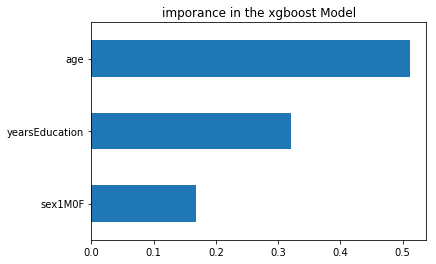

In [28]:
# feature importance のプロット
importances = pd.Series(xgr.feature_importances_, index = train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

* * *

# KFoldの使い方

- [model_selection](http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html)
- [cross_validation](http://scikit-learn.org/stable/modules/cross_validation.html)
- [model_evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)

In [15]:
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4],[3, 4], [7, 8], [6, 7], [7, 4]])
y = np.array([0, 0, 1, 1, 0, 0, 1, 0])
kf = KFold(n_splits=4)

print(kf)  

for train_index, test_index in kf.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)
   print("TRAIN:", len(train_index), "TEST:", len(test_index))
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

KFold(n_splits=4, random_state=None, shuffle=False)
TRAIN: [2 3 4 5 6 7] TEST: [0 1]
TRAIN: 6 TEST: 2
TRAIN: [0 1 4 5 6 7] TEST: [2 3]
TRAIN: 6 TEST: 2
TRAIN: [0 1 2 3 6 7] TEST: [4 5]
TRAIN: 6 TEST: 2
TRAIN: [0 1 2 3 4 5] TEST: [6 7]
TRAIN: 6 TEST: 2


# StratifiedKFoldの使い方

In [9]:
from sklearn.model_selection import StratifiedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4],[3, 4], [7, 8], [6, 7], [7, 4]])
y = np.array([0, 0, 1, 1, 0, 0, 1, 0])
skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X, y)

print(skf)  

for train_index, test_index in skf.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)
   print("TRAIN:", len(train_index), "TEST:", len(test_index))
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
TRAIN: [3 4 5 6 7] TEST: [0 1 2]
TRAIN: 5 TEST: 3
TRAIN: [0 1 2 5 6 7] TEST: [3 4]
TRAIN: 6 TEST: 2
TRAIN: [0 1 2 3 4 7] TEST: [5 6]
TRAIN: 6 TEST: 2
TRAIN: [0 1 2 3 4 5 6] TEST: [7]
TRAIN: 7 TEST: 1


/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


* * * * *

# モデルの.scoreとmodel_selection.cross_val_score

In [1]:
from sklearn import datasets, svm
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target
svc = svm.SVC(C=1, kernel='linear')

In [3]:
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.97999999999999998

In [4]:
import numpy as np
X_folds = np.array_split(X_digits, 3)
y_folds = np.array_split(y_digits, 3)
scores = list()
for k in range(3):
    # We use 'list' to copy, in order to 'pop' later on
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_train = np.concatenate(y_train)
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))

In [5]:
print(scores)

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]


In [6]:
from sklearn.model_selection import KFold, cross_val_score
X = ["a", "a", "b", "c", "c", "c"]
k_fold = KFold(n_splits=3)
for train_indices, test_indices in k_fold.split(X):
     print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [2 3 4 5] | test: [0 1]
Train: [0 1 4 5] | test: [2 3]
Train: [0 1 2 3] | test: [4 5]


### .scoreで出す。

In [11]:
[svc.fit(X_digits[train], y_digits[train]).score(X_digits[test], y_digits[test]) 
 for train, test in k_fold.split(X_digits)]

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]

### cross_val_scoreで出す。

In [9]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold, n_jobs=-1)

array([ 0.93489149,  0.95659432,  0.93989983])

In [12]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold,
                scoring='precision_macro')

array([ 0.93969761,  0.95911415,  0.94041254])